# Visualizing Indefinitely Many Simpson Reversals

## Contents

  1. Background
  2. Sample output
  3. Code
  4. Explaining the code

## 1. Background

For concreteness I'll focus on an imaginary drug trial. To assess the effectiveness of a drug, we give some patients ("the treatment group") the drug and other patients ("the control group") a placebo, and look at the recovery rates. The idea is: if the recovery rate is higher in the treatment group than the control group, that's evidence that the drug is beneficial; if the recovery rate is lower in the treatment group than the control group, that's evidence that the drug is harmful.

The following scenario, surprising as it seems initially, is in fact possible: the recovery rate is higher in the treatment group than the control group, but lower among men in the treatment group than men in the control group *and* lower among women in the treatment group than women in the control group. Following Judea Pearl I'll call this phenomenon a *Simpson reversal*.

When our data exhibit a Simpson reversal, what to conclude? We could go by the recovery rates overall, concluding that the drug is beneficial. Or we could go by the recovery rates in the two sub-populations, concluding that the drug is harmful. Pearl has argued (see e.g. "Causality: Models, Reasoning, and Inference") that the answer cannot be determined from the data itself, but depends in addition on the *causal story* behind the data. This debate is what makes Simpson reversals particularly interesting.

Your data could exhibit not just one but indefinitely many Simpson reversals. For example, comparing treatment group and control group, there might be:
  - overall, a *higher* recovery rate
  - for men and for women, *lower* recovery rates
  - for men over 50, men under 50, women over 50, and women under 50, *higher* recovery rates
  - for men over 50 with a comorbidity, men over 50 without a comorbidity, men under 50 with a comorbidity, men under 50 without a combordity, women over 50 with a comorbidity, women over 50 without a comorbidity, women under 50 with a comorbidity, women under 50 without a combordity, *lower* recovery rates
  - and so on.
  
This notebook lets you generate and visualize indefinitely many Simpson reversals.

## 2. Sample output

Here's an example of the kind of visualizations we get:

**overall, a higher recovery rate:**

![one reversal](reversal_1.png)

**for men and for women, *lower* recovery rates:**

![two reversals](reversal_2.png)

**for men over 50, men under 50, women over 50, and women under 50, *higher* recovery rates**

![three reversals](reversal_3.png)

**for men over 50 with a comorbidity, men over 50 without a comorbidity, men under 50 with a comorbidity, men under 50 without a combordity, women over 50 with a comorbidity, women over 50 without a comorbidity, women under 50 with a comorbidity, women under 50 without a combordity, *lower* recovery rates**

![four reversals](reversal_4.png)

How to interpret the images?

Focus for example on the two orange columns in the last image:

  - The *unhatched* orange column corresponds to men over 50 with a comorbidity, in the treatment group.
  - The *hatched* orange column corresponds to men over 50 with a comorbidity, in the control group.
  - The *height* of each column is the recovery rate in that sub-population.
  - The *width* of each column is the proportion of people who fall into that sub-population.
  
In the last picture, each unhatched column is shorter than the corresponding hatched column. That represents that for each of the eight sub-populations, the recovery rate is lower among the treatment group than the control group.

Each image is derived from the previous, as follows. We divide each column in two, giving a left child and a right child, ensuring that:

  1. the widths of the two children sum to the width of the parent
  2. the areas of the two children sum to the area of the parent
  3. the smaller parent yields the taller children

In other words, each image is derived from the previous by further dividing each sub-population in two, in such a way as to get a Simpson reversal. Section 4 gives more detail.

## 3. Code

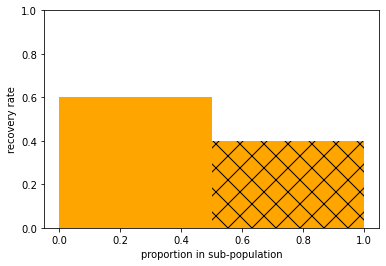

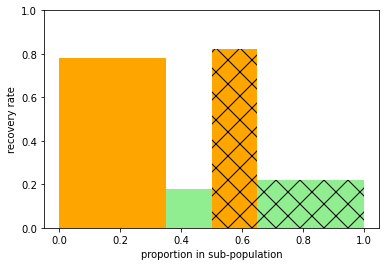

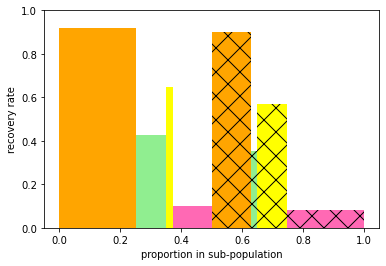

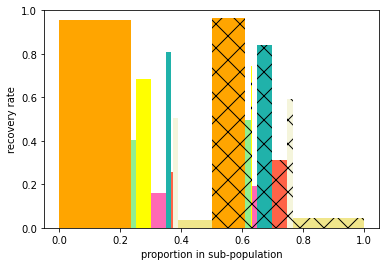

In [1]:
import matplotlib.pyplot as plt
import itertools
import more_itertools
import fractions
import math


def reverse_columns(tall_col, short_col):
    """Creates a Simpson reversal by dividing each column in two.

    A column is represented as a tuple (height, width). Assumes that tall_col
    is taller than short_col and that the heights are between 0 and 1.

    Args:
        tall_col: Tuple of floats. The height and width of the taller column.
        short_col: Tuple of floats. The height and width of the shorter column.

    Returns:
        Four columns. The first column is taller than the third, and the second
        is taller than the fourth. The sum of the areas of the first two columns
        equals the area of tall_col, and the sum of the areas of the last two
        columns equals the area of short_col.
    """

    # Must have: A, B, C, D in (0, 1), A < B, and C < D.
    # I chose the four values below somewhat arbitrarily, aiming
    #   to get easily interpreted images.
    A = 9/20
    B = 11/20
    C = 9/20
    D = 11/20

    # heights and widths of the given columns
    h_t, w_t = tall_col
    h_s, w_s = short_col

    # heights of the new columns
    h_tl = h_t + A*(1 - h_t)
    h_sl = h_t + B*(1 - h_t)
    h_tr = C*h_s
    h_sr = D*h_s

    # how far along, as a proportion of its width, to break each given column
    z_t = (h_t - C*h_s) / ((1 - A)*h_t + A - C*h_s)
    z_s = (h_s - D*h_s) / ((1 - B)*h_t + B - D*h_s)

    # defining the new columns
    tall_l = (h_sl, z_s * w_s)
    tall_r = (h_sr, (1 - z_s)*w_s)
    short_l = (h_tl, z_t * w_t)
    short_r = (h_tr, (1 - z_t)*w_t)

    return tall_l, tall_r, short_l, short_r


def next_layer(taller, shorter):
    """Returns the next layer in a Simpson tree.

    A layer in a Simpson tree is a list of two lists. Each list contains columns.
    Each column in the first list is taller than its counterpart in the second
    list.

    Args:
        taller: List of columns.
        shorter: List of columns.

    Returns:
        List of two lists. The first is a list of the new taller columns,
        constructed out of the given shorter columns. The second is a list of
        the new shorter columns, constructed out of the given taller columns.
    """
    new_taller, new_shorter = [], []

    for tall_col, short_col in zip(taller, shorter):
        tall_l, tall_r, short_l, short_r = reverse_columns(tall_col, short_col)
        new_taller += [tall_l, tall_r]
        new_shorter += [short_l, short_r]

    return [new_taller, new_shorter]


def simpson_tree(first_layer, k):
    """Returns a Simpson tree, k layers deep.

    Args:
        first_layer: List of two lists, the two initial columns.
        k: The depth of the tree to be generated.

    Returns:
        A Simpson tree, which is a dictionary, mapping an index to the
        corresponding layer in the tree.
    """
    tree = {1 : first_layer}

    for i in range(2, k+1):
        taller, shorter = tree[i-1]
        tree[i] = next_layer(taller, shorter)

    return tree


def cum_steps(lst):
    """Returns a stream of pairs, overlapping, in the accumulated list.

    For example, [1, 2, 3, 4] -> (0, 1), (1, 3), (3, 6), (6, 10).
    """
    return more_itertools.pairwise(
        itertools.accumulate([0] + lst))


def draw_layer(layer):
    """Creates a matplotlib figure to visualize a layer in a Simpson tree.

    Args:
        layer: List of two lists, a layer in a Simpson tree.
    """

    colors = ['orange', 'lightgreen', 'yellow', 'hotpink',
              'lightseagreen', 'tomato', 'beige', 'khaki',
              'cyan', 'lightsalmon', 'thistle', 'gainsboro',
              'lavenderblush', 'goldenrod', 'lightskyblue', 'greenyellow']

    taller, shorter = layer
    heights = [tall[0] for tall in taller] + [short[0] for short in shorter]
    widths = [tall[1] for tall in taller] + [short[1] for short in shorter]
    n = len(heights)
    xx = cum_steps(widths)

    fig, ax = plt.subplots()

    for (x1, x2), height, i in zip(xx, heights, itertools.count()):
        hatch = 'x' if i >= n/2 else ''
        ax.fill_between([x1, x2], 0, height,
                        hatch=hatch, facecolor=colors[i % (n//2)])

    ax.set_xlabel('proportion in sub-population')
    ax.set_ylabel('recovery rate')
    ax.set_ylim([0, 1])

    return fig, ax


def draw_layers(first_layer, k):
    """Creates multiple matplotlib figures to visualize each layer in a Simpson tree.

    Args:
        first_layer: List of two lists, each containing a single column.
          Represents the size and recovery rates of the treatment and
          control groups.
        k: The number of images to draw, one for each layer in the
          tree to be generated.
    """
    tree = simpson_tree(first_layer, k)

    for i in tree:
        # Because the taller columns come first in each layer, we need to
        #   reverse every other layer, so that (e.g.) the treatment population
        #   stays on the left and the control population stays on the right.
        layer = tree[i][::-1] if i%2 == 0 else tree[i]
        draw_layer(layer)


def to_fractions(layer):
    """Returns a new layer, where each float has been converted to a Fraction.

    Args:
        layer: List of two lists, a layer in a Simpson tree.
    """
    try:
        return [fractions.Fraction(i).limit_denominator() for i in layer]
    except:
        return [to_fractions(i) for i in layer]


def lcm(iterable):
    """Returns the least common multiple of an iterable of numbers."""
    lcm = 1
    for i in iterable:
        lcm = lcm * i // math.gcd(lcm, i)
    return lcm


def to_data(tree):
    """Prints integer data corresponding to a Simpson tree.

    A Simpson tree contains floats, representing various proportions of the
    population. This function "denormalizes" the tree, turning proportions into
    counts, and prints them. It should find the smallest population size
    consistent with the given tree.

    Args:
        tree: A Simpson tree, which is a dictionary, mapping an index to the
        corresponding layer in the tree.
    """
    f_tree = {k: to_fractions(v) for k, v in tree.items()}
    height_denoms, width_denoms = [], []

    # extract denominators
    for k in f_tree:
        taller, shorter = f_tree[k]
        for h, w in taller:
            height_denoms.append(h.denominator)
            width_denoms.append(w.denominator)
        for h, w in shorter:
            height_denoms.append(h.denominator)
            width_denoms.append(w.denominator)

    height_multiplier = lcm(height_denoms)
    width_multiplier = lcm(width_denoms)
    n = height_multiplier * width_multiplier # total population size

    for k in f_tree:

        # Taller columns always come first in f_tree
        #   so we need to reverse every other layer.
        treatment, control = f_tree[k][(k+1) % 2], f_tree[k][k%2]

        # e.g. subpopulations in the third layer are labeled 00, 01, 10, 11
        labels = [''.join(word)
                  for word in itertools.product(('0', '1'), repeat=k-1)]

        # When k==1, we should just print: a out of b people recovered.
        # When k>1, we should prefix that with the subpopulation's label.
        prefix = 'In sub-population ' if k > 1 else ''
        middle = ', ' if k > 1 else ''
        print(f'\n***LAYER {k}***')

        print('\nTREATMENT GROUP')
        for (h, w), label in zip(treatment, labels):
            print(prefix + f'{label}' \
                  + middle + f'{h*w*n} out of {w*n} people recovered.')

        print('\nCONTROL GROUP')
        for (h, w), label in zip(control, labels):
            print(prefix + f'{label}' + \
                  middle + f'{h*w*n} out of {w*n} people recovered.')

# If you uncomment the two lines below and run the cell, you should get the images shown above.
first_layer = [[(3/5, .5)], [(2/5, .5)]]
draw_layers(first_layer, 4)

In [2]:
# If you uncomment the line below and run the cell, you should
#   get count data corresponding to the images above.
tree = simpson_tree(first_layer, 4)
to_data(tree)


***LAYER 1***

TREATMENT GROUP
2461122045865238460629148754280126912681168562000000 out of 4101870076442064101048581257133544854468614270000000 people recovered.

CONTROL GROUP
1640748030576825640419432502853417941787445708000000 out of 4101870076442064101048581257133544854468614270000000 people recovered.

***LAYER 2***

TREATMENT GROUP
In sub-population 0, 2239621061737366999172525366394915490539863391420000 out of 2871309053509444870734006879993481398128029989000000 people recovered.
In sub-population 1, 221500984127871461456623387885211422141305170580000 out of 1230561022932619230314574377140063456340584281000000 people recovered.

CONTROL GROUP
In sub-population 0, 1009060038804747768857950989254852034199279110420000 out of 1230561022932619230314574377140063456340584281000000 people recovered.
In sub-population 1, 631687991772077871561481513598565907588166597580000 out of 2871309053509444870734006879993481398128029989000000 people recovered.

***LAYER 3***

TREATMENT GROUP
In sub

## 4. Explaining the code

Given two columns, possibly of different widths and heights, we need to split each in two such that 

  1. the widths of the two children sum to the width of the parent
  2. the areas of the two children sum to the area of the parent
  3. the taller column yields the shorter children
  
The picture below shows the situation. The original columns are shown by the solid lines. The desired new columns are shown by the dashed lines. We need to find suitable values for \$ h_{tl}, z_t, h_{tr} \$ and \$ h_{sl}, z_s, h_{sr} \$.

We take \$ z_t \$ to be a proportion of the original left column's width, so is in \$ (0, 1) \$, and similarly for \$ z_s \$. And we take all the heights to be in \$ (0, 1) \$ too.

<img src="dividing_columns.png" alt="the idea behind the code" style="width: 500px;"/>

For any \$ \alpha < \beta, \gamma < \delta \$, all between 0 and 1, we can set:

  1. \$ h_{tl} = h_t + \alpha(1 - h_t) \$
  2. \$ h_{sl} = h_t + \beta(1 - h_t) \$
  3. \$ h_{tr} = \gamma h_s \$
  4. \$ h_{sr} = \delta h_s \$
  
Because we need to preserve areas, we must have:

  5. \$ h_t = h_{tl} \cdot z_b + h_{tr} \cdot (1 - z_t) \$
  6. \$ h_s = h_{sl} \cdot z_s + h_{sr} \cdot (1 - z_s) \$
  
Substituting 1-4 into 5 and 6 and re-arranging yields:

  7. \$ z_t = \frac{h_t - \gamma h_s}{(1 - \alpha)h_t + \alpha - \gamma h_s} \$
  
and 

  8. \$ z_s = \frac{h_s - \delta h_s}{(1 - \beta)h_t + \beta - \delta h_s} \$
  
The code above splits each pair of columns, one from the treatment group and one from the control group, according to this recipe.

I chose particular values of the free parameters \$ \alpha, \beta, \gamma, \delta \$ somewhat arbitrarily. You can change them if you like. You could even change them from pair of columns to pair of columns, to get finer control, though that would require a bit more work.

You can visualize how the code work by imagining a *Simpson tree*, of which a few layers are shown here:

<img src="simpson_tree.png" alt="the idea behind the code" style="width: 500px;"/>

In general, a Simpson tree is an infinite binary tree at each node of which lives a column, represented by a tuple of its height and width. At the root node lives (1, 1), representing the entire population. It has two children, specified manually, representing the recovery rates and sizes of the treatment and control groups. Subsequent layers in the tree are generated on demand according to the recipe above, getting a Simpson reversal from each layer to the next.